# 📖 Feedback Prize - Sentence Classifier using Machine learning

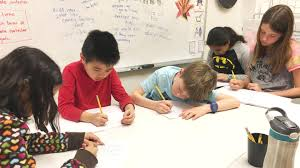

## Please, _DO_ upvote if you find it useful or interesting!! 

# load Data

In [ ]:
# import training dataset
import pandas as pd
df = pd.read_csv("../input/feedback-prize-2021/train.csv")
df.head()

In [ ]:
df.shape

In [ ]:
# load other datasets (this is mainly used for validation purpose)
train_text_path = "../input/feedback-prize-2021/train"
test_text_path = "../input/feedback-prize-2021/test"

# 1. EDA

#### Understanding dataset with simple Amazon product reviews Ex.mobile 

Review - amazon product
- / train
- - review1.txt
- - review2.txt
- review1.txt: camera is not good. battery is working good.

-/ train.csv
| discourse_text      | discourse_type |
| camera is not good  | camera |
| battery is working good | battery |

-----
- train - model building
- test - validation --> calculate accuracy
- test - submission

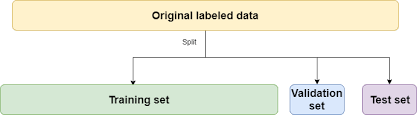

## From the [Data tab](https://www.kaggle.com/c/feedback-prize-2021/data):

> *  id -                 ID code for essay response
> *  discourse_id -       ID code for discourse element
> *  discourse_start -    character position where discourse element begins in the essay response
> *  discourse_end -      character position where discourse element ends in the essay response
> *  discourse_text -     text of discourse element
> *  discourse_type -     classification of discourse element
> *  discourse_type_num - enumerated class label of discourse element
> *  predictionstring -   the word indices of the training sample, as required for predictions

## Let's see the first example in some more detail

In [ ]:
# read .txt file 
path = '../input/feedback-prize-2021/train/423A1CA112E2.txt'
with open(path, "r") as fp:
    txt = fp.read()
print(txt)

In [ ]:
text_id = df['id'][0]
text_id

In [ ]:
def get_text(file_id):
    # creating a file path
    a_file = f"{train_text_path}/{file_id}.txt"
    
    # read .txt file 
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

txt = get_text(text_id)
print(txt)

In [ ]:
df_example = df[df['id'] == text_id]
df_example

In [ ]:
# Creadits for this part of visualisation _> https://www.kaggle.com/thedrcat
import spacy
from spacy import displacy
from pylab import cm, matplotlib

colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }

def visualize(example, df):
    ents = []
    for i, row in df[df['id'] == example].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })
        
    with open(f'{train_text_path}/{example}.txt', 'r') as file: data = file.read()
    doc2 = {
                "text": data,
                "ents": ents,
                "title": example
            }

    options = {"ents": df.discourse_type.unique().tolist(), "colors": colors}
    displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True)

In [ ]:
examples = df['id'].sample(n=1, random_state=42).values.tolist()
for ex in examples:
    visualize(ex,df)
    print('\n')

# 2. Data processing 

## Check For Null Values 
we can see that there are no null values in the dataset

In [ ]:
# No nulls
df.isnull().sum()

In [ ]:
# check value count of response variable
df.discourse_type.value_counts()

# optional way
df['discourse_type'].value_counts()

In [ ]:
new_df = pd.DataFrame(columns=['text', 'label'])
new_df['text'] =  df['discourse_text'] 
new_df['label'] = df['discourse_type']
new_df.head()

In [ ]:
new_df.shape

## For performance and visualization reasons, we'll only use 5,000 sentences from the dataset

### lets learn Text classification zero to BERT

In [ ]:
# select first 5000 obs for fast run on colab
new_df = new_df[:5000]
new_df.shape

# 3. Text processing

- I've given better version of text clearning and procesing(mainly used in quite messy and unclean data like twitter).
- This data is clean, you can ignore few steps of clearning process.

In [ ]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import re
from nltk.corpus import stopwords

ps = PorterStemmer() 
def text_process(text):
    # lower case
    text = text.lower()
    # remove emails
    text= ' '.join([i for i in text.split() if '@' not in i])
    # remove urls
    text = re.sub(r'http\S+|www\S+', '', text)
    # remove irrelevant characters other than numbers and space
    text = re.sub('[^A-Za-z\s]+', ' ', text)
    # remove numbers
    text =  re.sub(r'\d+', '', text)
    #remove white spaces
    text = re.sub(r'\s+', ' ', text)
    #remove unwanted words with string
    text=re.sub(r'\d+\W','',text)
    # Remove HTML Tag
    text=re.sub(r'<[^>]+>','',text)
    
    
    # Use tokenizer
    words = word_tokenize(text)
    # remove Stop words from text
    stop = stopwords.words('english')
    words=[x for x in words if x not in stop]
    text=' '.join(words)
    return text.strip()

In [ ]:
text = "Hello🙂... x@xwy.in my s@gmail.com “name” (is) #shweta!!!!  7$  ] 100%  } ] http//:vision.com https://vision.com and your???,,,,, ???? name \ is / www.fb.com "
text_process(text)

In [ ]:
#apply text processing
# colum in pandas data
#1. new_df['text']
#2. new_df.text
new_df = new_df[new_df.text.str.split().str.len() >= 3]

new_df['text'] = new_df['text'].apply(lambda x: text_process(x))
new_df.head(1)

## categorical variable to numerical for model building

In [ ]:
new_df['category_id'] = new_df['label'].factorize()[0]
new_df.head(1)

In [ ]:
new_df['category_id'].unique().tolist()

In [ ]:
# create a dictionary of id and class (this will help in prediction purpose)
id_to_category = dict(enumerate(new_df['label'].unique().tolist()))
category_to_id = {v: k for k, v in id_to_category.items()}
print(id_to_category)
print(category_to_id)

In [ ]:
# model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

In [ ]:
X = new_df['text'] # features
y = new_df['category_id'] # labels

# 4. Word Emeddings 

**In classification of text, for the text we can call sentence, row or document.**

**generate numbers from raw texts**

### context free
1. Bag of words - simple method
2. tf-idf - statistical

### context free
3. word2vec - statistical + deep learning(newural networks)
4. glove 

### contextual
5. EMLo
6. bert

## 1. Bag of words
- In this algorithm we basically calculates frequecy of each word means how frequent each word appears in different documents
- Here we will implement Bag of words (BoW) model
- Bag of words model helps convert the text into numerical representation (numerical feature vectors) , later this feature vector will be used to train ML models
- The below picture explains the above concepts:

For example, for the first document, “bird” occured for 5 times, “the” occured for two times and “about” occured for 1 time.

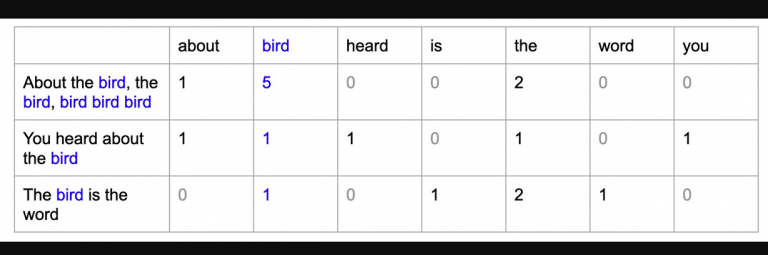

In python we use **CountVectorizer** class from scikit-learn 

In [ ]:
# maths calculation
import numpy as np

# word embeddings / feature extraction
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# Create sample set of documents
docs = np.array(['Mirabai has won a silver medal in weight lifting in Tokyo olympics 2021',
                 'Sindhu has won a bronze medal in badminton in Tokyo olympics'])

# Fit the bag-of-words model df.text
bag = vectorizer.fit_transform(docs)

# Associate the indices with each unique word
print(vectorizer.vocabulary_)

print("---------------------------------")
# Print the numerical feature vector
print(bag.toarray())

## 2. tf-idf

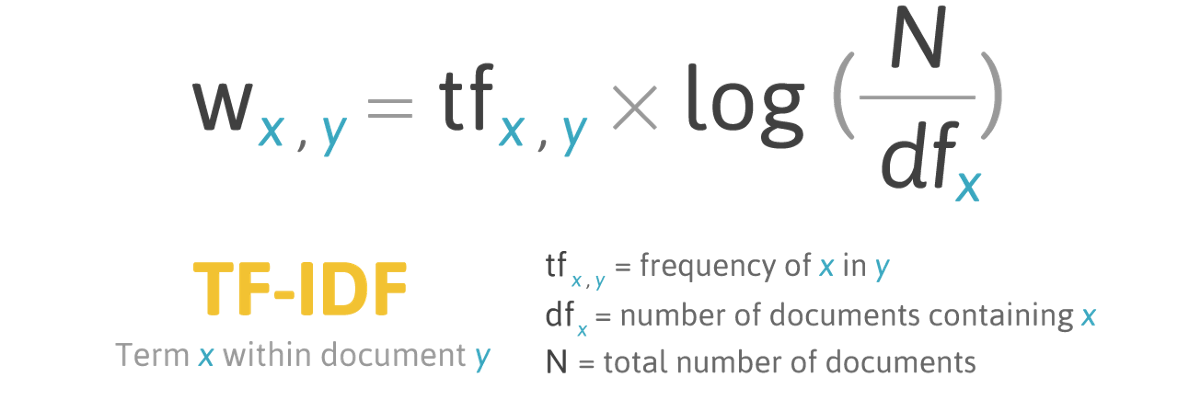

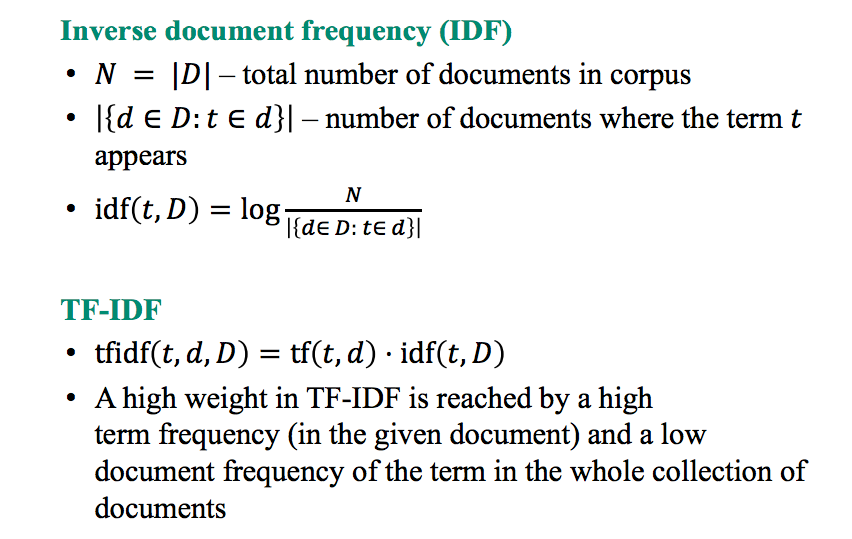

- tf-idf is used in the fields of information retrieval (IR) and machine learning text classification.
- The tf–idf value increases proportionally to the:-
- - number of times  a word appears in the document and the number of documents in the corpus that contain the word
- which helps to adjust for the fact that some words appear more frequently in general. 

**inverse document frequency: This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is.**

**tf-idf: The higher the score, the more relevant that word is in that particular document.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create object
tfidf = TfidfVectorizer()

# assign documents
d0 = 'VisionNLP for nlp'
d1 = 'VisionNLP'
d2 = 'VisionNLP vision nlp'
# merge documents into a single corpus
string = [d0, d1, d2]

# get tf-df values 
result = tfidf.fit_transform(string)

# get idf values
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names(), tfidf.idf_):
    print(ele1, ':', ele2)

In [ ]:
# get indexing
print('\nWord indexes:')
print(tfidf.vocabulary_)
  
# display tf-idf values
print('\ntf-idf value:')
print(result)
  
# in matrix form
print('\ntf-idf values in matrix form:')
print(result.toarray())

tf-idf values: 
- first value in tuple is document index
- second value in tuple is word index


In [ ]:
# word embeddings / feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(X).toarray()
labels = y

In [ ]:
# train and test spliiting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, random_state=42)
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test

In [ ]:
# model building
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict( X_test )
y_pred

In [ ]:
y_test

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
cohen_kappa_score(y_test,y_pred)

In [ ]:
from sklearn.svm import SVC # SVM
model=SVC(C=1, gamma=1, kernel='linear',probability=True)
#Train Algorithm
model.fit(X_train, y_train)

In [ ]:
# model evaluation
y_pred = model.predict( X_test )
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# save the model to disk
import pickle
filename = 'finalized_model.pickle'
pickle.dump(clf, open(filename, 'wb'))